In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import multihist as mh
import _pickle as pickle
import scipy.interpolate as itp
import click

import strax, straxen, wfsim, cutax
import nestpy
import datetime, os
from tqdm.notebook import tqdm
from datetime import datetime

*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [2]:
straxen.print_versions(('strax','straxen','cutax','wfsim'))

Working on midway2-0416.rcc.local with the following versions and installation paths:
python	v3.8.12	(default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
strax	v1.1.1	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax
straxen	v1.1.2	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/straxen
cutax	v0.2.2	/dali/lgrandi/xenonnt/software/cutax/latest/cutax
wfsim	v0.5.9	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/wfsim


### Get high statistics SN data

In [3]:
st = cutax.contexts.xenonnt_sim_SR0v0_cmt_v5(output_folder='/dali/lgrandi/melih/sn_wfsim/strax_data')
st.set_config(dict(fax_config_override=dict(field_distortion_on=False)))

rid = 'SN_wfsimdata_100k'
print(f'---> Data for "{rid}" ')
for kind in ['truth', 'raw_records', 'peaks', 'peak_basics']:
    click.echo(f'{kind:15s} is {click.style(" stored ", bold=True, bg="green") if st.is_stored(rid, kind) else click.style(" not stored ",bold=True,bg="red")}')

---> Data for "SN_wfsimdata_100k" 
truth           is  stored 
raw_records     is  stored 
peaks           is  not stored 
peak_basics     is  stored 


/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax/context.py:1456: UserWarning: Option gain_model_nv not taken by any registered plugin
  plugins = self._get_plugins((target,), run_id)
/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax/context.py:1456: UserWarning: Option gain_model_mv not taken by any registered plugin
  plugins = self._get_plugins((target,), run_id)


In [4]:
truth = st.get_df(rid,('truth'))
peak_basics = st.get_df(rid, 'peak_basics')
event_info = st.get_df(rid, 'event_info')

Loading truth: |          | 0.00 % [00:00<?]

Loading peak_basics: |          | 0.00 % [00:00<?]

/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax/context.py:723: UserWarning: Option gain_model_nv not taken by any registered plugin
  plugins = self._get_plugins(targets, run_id)
/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax/context.py:723: UserWarning: Option gain_model_mv not taken by any registered plugin
  plugins = self._get_plugins(targets, run_id)


Loading event_info: |          | 0.00 % [00:00<?]

### Get also a single SN event

In [5]:
st.set_config(dict(nearby_window=5e8))
st.set_config(dict(fax_config_override=dict(field_distortion_on=False)))
st.set_config(dict(fax_file=f'/dali/lgrandi/melih/sn_wfsim/instructions/single_SN.csv'))
rid_single = 'sn_simple'

print(f'---> Data for "{rid_single}" ')
for kind in ['truth', 'raw_records', 'peaks', 'peak_basics']:
    click.echo(f'{kind:15s} is {click.style(" stored ", bold=True, bg="green") if st.is_stored(rid, kind) else click.style(" not stored ",bold=True,bg="red")}')

---> Data for "sn_simple" 
truth           is  stored 
raw_records     is  stored 
peaks           is  not stored 
peak_basics     is  stored 


/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax/context.py:1456: UserWarning: Option gain_model_nv not taken by any registered plugin
  plugins = self._get_plugins((target,), run_id)
/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax/context.py:1456: UserWarning: Option gain_model_mv not taken by any registered plugin
  plugins = self._get_plugins((target,), run_id)


In [6]:
truth_single = st.get_df(rid_single,('truth'))
peak_basics_single = st.get_df(rid_single, 'peak_basics')
event_info_single = st.get_df(rid_single, 'event_info')

Loading truth: |          | 0.00 % [00:00<?]

Loading peak_basics: |          | 0.00 % [00:00<?]

/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax/context.py:723: UserWarning: Option gain_model_nv not taken by any registered plugin
  plugins = self._get_plugins(targets, run_id)
/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax/context.py:723: UserWarning: Option gain_model_mv not taken by any registered plugin
  plugins = self._get_plugins(targets, run_id)


Loading event_info: |          | 0.00 % [00:00<?]

### Get a background run

In [7]:
st_runs = cutax.xenonnt_v5(cuts_for='commissioning.commissioning_cuts', _minimum_run_number=17917)

In [8]:
# exclude_tags = ('flash', 'ramp_up', 'ramp_down', 'anode_off', 'hot_spot', 'missing_one_pmt', 'messy', 'bad')

# # Not tpc_radon
# runs_bkg = st_runs.select_runs(run_mode='tpc_bkg', include_tags=('_sr0_*'), 
#                                exclude_tags=exclude_tags,  available=('event_basics'), 
#                                ignore_underscore=True)

# bkg_run_id = runs_bkg.sample()['name'].values[0]

In [9]:
bkg_run_id = '019537'
st_runs.set_config(dict(nearby_window=5e8)) # half a second in each direction
peaks_run = st_runs.get_df(bkg_run_id, ('peak_proximity', 'peak_basics'))
peak_prox_rate = peaks_run['n_competing'] / st_runs.config['nearby_window']

Loading plugins: |          | 0.00 % [00:00<?]

**Auxiliary scripts**

In [10]:
def display_times(arr):
    """ times array in ns
    """
    ti = int(arr.min()/1e9)
    tf = int(arr.max()/1e9)
    print(ti, datetime.utcfromtimestamp(ti).strftime('%Y-%m-%d %H:%M:%S'))
    print(tf, datetime.utcfromtimestamp(tf).strftime('%Y-%m-%d %H:%M:%S'))
    timedelta = datetime.utcfromtimestamp(tf)-datetime.utcfromtimestamp(ti)
    print(f'{timedelta.seconds} seconds \n{timedelta.resolution} resolution')
    
def get_rate(arr, sampling=1e9):
    interval_array = np.arange(arr.min(), arr.max() + sampling , sampling) # in seconds
    rates = np.zeros(len(interval_array[:-1]))
    for i, time in enumerate(interval_array[:-1]):
        dists = arr - time
        entries = ((dists < sampling) & (dists > 0)).sum()
        rates[i] = entries
        
    times = interval_array[:-1] + sampling/2
    return times, np.array(rates)/sampling

def inject_in(small_signal, big_signal):
    # bring the small signal to zero
    small_signal['time'] -= small_signal['time'].min()
    # push it inside the big signal
    small_signal['time'] += np.random.choice(big_signal['time'])
    # check
    for time in small_signal['time']:
        if np.isclose(time, any(big_signal['time']), rtol=1e-8):
            print('Unlucky guess!')
            return inject_in(small_signal, big_signal)
    
    times_bkg = big_signal['time'].values
    times_sn =  small_signal['time'].values
    if (times_bkg.min() < times_sn.min()) & (times_bkg.max() > times_sn.max()):
        return small_signal
    else: print('something went wrong!')

In [11]:
display_times(peaks_run['time'])

1621249391 2021-05-17 11:03:11
1621251194 2021-05-17 11:33:14
1803 seconds 
0:00:00.000001 resolution


In [12]:
display_times(peak_basics_single['time'])

0 1970-01-01 00:00:00
1 1970-01-01 00:00:01
1 seconds 
0:00:00.000001 resolution


We need to inject this inside the runs time interval.

In [16]:
signal = inject_in(peak_basics_single, peaks_run)

In [17]:
display_times(signal['time'])

1621249994 2021-05-17 11:13:14
1621249996 2021-05-17 11:13:16
2 seconds 
0:00:00.000001 resolution


Now it is inside our background run!

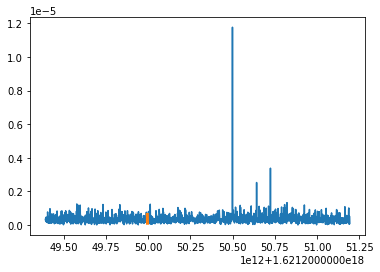

In [20]:
t_run, r_run = get_rate(peaks_run['time'])
t_sn, r_sn = get_rate(signal['time'])

plt.plot(t_run, r_run, label='BG Rates')
plt.plot(t_sn, r_sn*10, label='SN signal x10', lw=3);

### Cleaning
The SN signal only visible when amplified by 100. We should clean the background run to have a more stable signal.

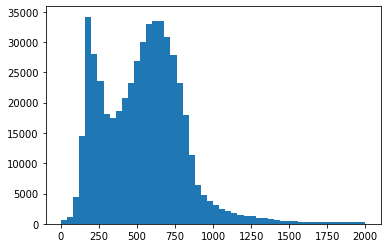

In [21]:
# st_runs.data_info('peak_basics')
plt.hist(peaks_run['range_90p_area'], 50, range=(0,2e3));

In [22]:
m1 = peaks_run['type'] == 2
m2 = peaks_run['area'] < 600
m3 = peaks_run['range_90p_area'] < 1000
m4 = peaks_run['range_90p_area'] > 300
masks = m1 & m2 & m3 & m4
peaks_bg_filt = peaks_run[masks]

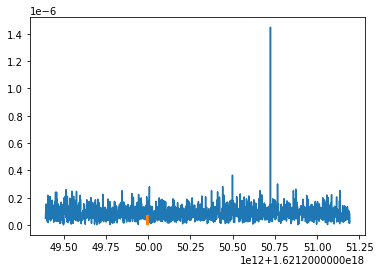

In [23]:
t_run, r_run = get_rate(peaks_bg_filt['time'])
t_sn, r_sn = get_rate(signal['time'])

plt.plot(t_run, r_run, label='BG Rates')
plt.plot(t_sn, r_sn, label='SN signal', lw=3);

Some initial cuts already give nice results. Tune these cuts using higher statistics data.

In [24]:
s2_runs = peaks_run[(peaks_run['type']==2)&(peaks_run['area']<2000)]

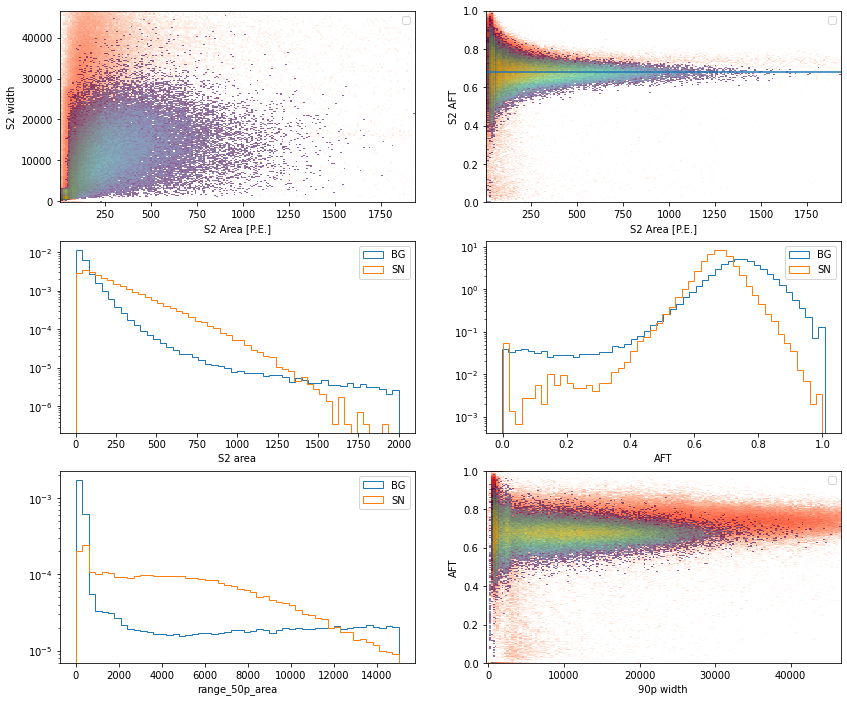

In [25]:
s2_peaks = peak_basics[(peak_basics['type']==2)&(peak_basics['area']<2000)]
s1_peaks = peak_basics[peak_basics['type']==1]

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(14,12))
ax[0,0].hist2d(s2_runs['area'], s2_runs['range_90p_area'], bins=(200,200), norm=LogNorm(), cmap='Reds');
ax[0,0].hist2d(s2_peaks['area'], s2_peaks['range_90p_area'], bins=(200,200), norm=LogNorm(), alpha=0.6);
ax[0,0].set_xlabel('S2 Area [P.E.]'); ax[0,0].set_ylabel('S2 width');

ax[0,1].hist2d(s2_runs['area'], s2_runs['area_fraction_top'], bins=(200,200), norm=LogNorm(), cmap='Reds');
ax[0,1].hist2d(s2_peaks['area'], s2_peaks['area_fraction_top'], bins=(200,200), norm=LogNorm(), alpha=0.6);
ax[0,1].set_xlabel('S2 Area [P.E.]'); ax[0,1].set_ylabel('S2 AFT');
ax[0,1].axhline(0.68);

ax[1,0].hist(s2_runs['area'], bins=50, histtype='step', density=True, label='BG');
ax[1,0].hist(s2_peaks['area'], bins=50, histtype='step', density=True, label='SN');
ax[1,0].set_xlabel('S2 area')
ax[1,0].set_yscale('log')

ax[1,1].hist(s2_runs['area_fraction_top'], bins=50, histtype='step', density=True, label='BG');
ax[1,1].hist(s2_peaks['area_fraction_top'], bins=50, histtype='step', density=True, label='SN');
ax[1,1].set_xlabel('AFT')
ax[1,1].set_yscale('log')


ax[2,0].hist(s2_runs['range_50p_area'], bins=50, histtype='step', density=True, label='BG', range=(0,15_000));
ax[2,0].hist(s2_peaks['range_50p_area'], bins=50, histtype='step', density=True, label='SN', range=(0,15_000));
ax[2,0].set_xlabel('range_50p_area')
ax[2,0].set_yscale('log')

ax[2,1].hist2d(s2_runs['range_90p_area'], s2_runs['area_fraction_top'], bins=(200,200), norm=LogNorm(), cmap='Reds');
ax[2,1].hist2d(s2_peaks['range_90p_area'], s2_peaks['area_fraction_top'], bins=(200,200), norm=LogNorm(), alpha=0.6);
ax[2,1].set_xlabel('range_90p_area')
ax[2,1].set_xlabel('90p width')
ax[2,1].set_ylabel('AFT')

for a in ax.ravel():
    a.legend();

In [224]:
# st_runs.data_info('peak_basics')

In [225]:
def tune_param(signal1, signal2, param='area_fraction_top'):
    """ Return the best cut value
    """
    surv_rat = lambda sig, cut: (len(sig)-len(sig[sig<cut]))/len(sig)
    best = 0
    cut_val = 0
    for cut in np.arange(0,1,0.05):
        surv_ratio_bg = surv_rat(signal1,cut)
        surv_ratio_sn = surv_rat(signal2,cut)
        proxy = surv_ratio_sn - surv_ratio_bg
        if proxy > best:
            best = proxy
            cut_val = cut
    return cut_val

In [226]:
signal1 = s2_runs['area_fraction_top']
signal2 = s2_peaks['area_fraction_top']

# signal1 = s2_runs['range_90p_area']
# signal2 = s2_peaks['range_90p_area']

cut = tune_param(signal1, signal2)
cut

0.5

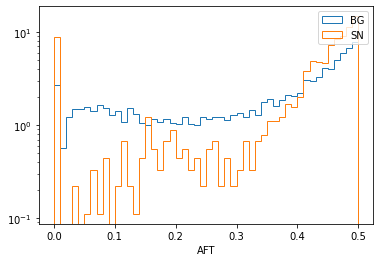

In [237]:
plt.hist(signal1[signal1 < cut], bins=50, histtype='step', density=True, label='BG', range=(0, cut));
plt.hist(signal2[signal2 < cut], bins=50, histtype='step', density=True, label='SN', range=(0, cut));
plt.xlabel('AFT');
plt.legend()
plt.gca().set_yscale('log')

Let's try these cuts.

In [259]:
m1 = peaks_run['type'] == 2
m2 = peaks_run['area'] < 600
m3 = peaks_run['range_50p_area'] < 15_000
m4 = peaks_run['range_50p_area'] > 0
m5 = peaks_run['area_fraction_top'] < 0.5
m6 = (peaks_run['time'] > signal['time'].mean()*.95) & (peaks_run['time'] < signal['time'].mean()*1.05)
masks = m1 & m2 & m3 & m4 & m5 & m6
peaks_bg_filt = peaks_run[masks]
peaks_bg_filt.shape

(7600, 22)

In [260]:
signal_filt = signal[signal['type']==2]

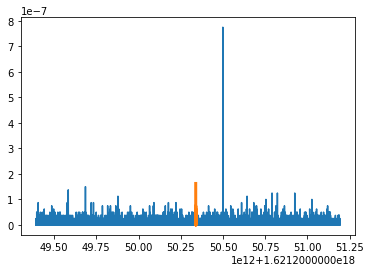

In [265]:
t_run, r_run = get_rate(peaks_bg_filt['time'], 8e7)
t_sn, r_sn = get_rate(signal_filt['time'], 8e7)

plt.plot(t_run, r_run, label='BG Rates')
plt.plot(t_sn, r_sn, label='SN signal', lw=3);

Lower level data? Pulses? We should be able to trigger as we read the data. <br>

I think my current rate scan takes discrete steps, but maybe I should move finer? I mean, take 0.5sec steps, compute the rate in the next 5 seconds. That should be more efficient.

In [273]:
test_bg_data.keys()

Index(['time', 'endtime', 'center_time', 'area', 'n_channels', 'max_pmt',
       'max_pmt_area', 'n_saturated_channels', 'range_50p_area',
       'range_90p_area', 'area_fraction_top', 'length', 'dt', 'rise_time',
       'tight_coincidence', 'tight_coincidence_channel', 'type', 'n_competing',
       'n_competing_left', 't_to_prev_peak', 't_to_next_peak',
       't_to_nearest_peak'],
      dtype='object')

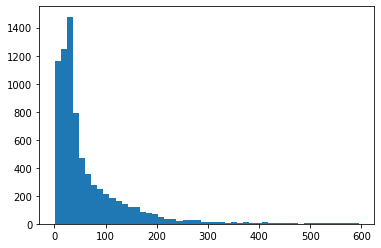

In [275]:
time_of_peak = t_run[np.where(r_run == r_run.max())[0][0]]
test_bg_data = peaks_bg_filt.copy()
test_bg_data = test_bg_data[(test_bg_data['time'] < time_of_peak*1.05)&(test_bg_data['time'] > time_of_peak*.95)]
plt.hist(test_bg_data['area'], bins=50);

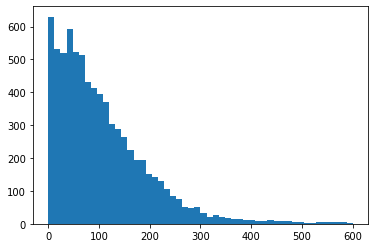

In [278]:
plt.hist(peaks_bg_filt['n_competing_left'], 50, range=(0,600));

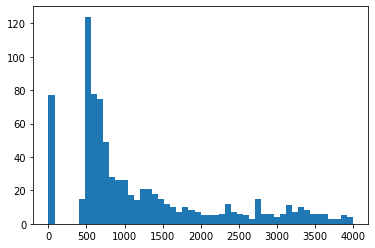

In [286]:
plt.hist(peaks_bg_filt['t_to_nearest_peak'][peaks_bg_filt['t_to_nearest_peak']>0], 50, range=(0,4000));

In [287]:
st_runs.data_info('peaks')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int32,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,type,int8,Classification of the peak(let)
5,area,float32,Integral across channels [PE]
6,area_per_channel,"('<f4', (494,))",Integral per channel [PE]
7,n_hits,int32,Number of hits contributing at least one sampl...
8,data,"('<f4', (200,))",Waveform data in PE/sample (not PE/ns!)
9,width,"('<f4', (11,))",Peak widths in range of central area fraction ...


In [288]:
st_runs.data_info('raw_records')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,pulse_length,int32,Length of pulse to which the record belongs (w...
5,record_i,int16,Fragment number in the pulse
6,baseline,int16,Baseline determined by the digitizer (if this ...
7,data,"('<i2', (110,))",Waveform data in raw ADC counts


Text(0, 0.5, 'aft')

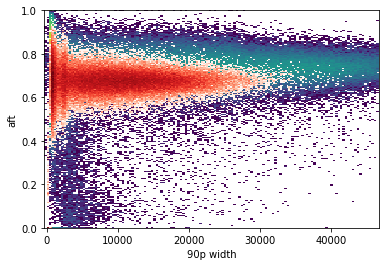

In [46]:
a, b = s2_runs['range_90p_area'], s2_runs['area_fraction_top']
c, d = s2_peaks['range_90p_area'], s2_peaks['area_fraction_top']
# a = a[(a>0) & (b>0)]
# b = b[(a>0) & (b>0)]
plt.hist2d(a,b, bins=(200,200), norm=LogNorm()); # , range=((0, 0.01e6),(0,1.3))
plt.hist2d(c,d, bins=(200,200), norm=LogNorm(), cmap='Reds'); # , range=((0, 0.01e6),(0,1.3))
plt.xlabel('90p width')
plt.ylabel('aft')

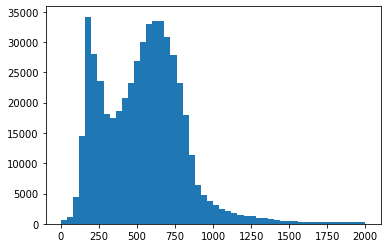

In [47]:
plt.hist(peaks_run['range_90p_area'], 50, range=(0,2e3));

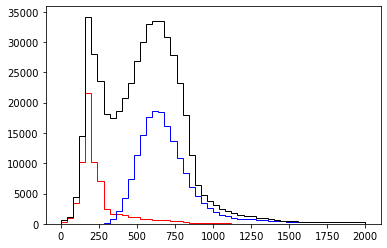

In [50]:
plt.hist(peaks_run['range_90p_area'][peaks_run['type']==1], 50, range=(0,2e3), histtype='step', color='red');
plt.hist(peaks_run['range_90p_area'][peaks_run['type']==2], 50, range=(0,2e3), histtype='step', color='blue');
plt.hist(peaks_run['range_90p_area'], 50, range=(0,2e3), histtype='step', color='k');

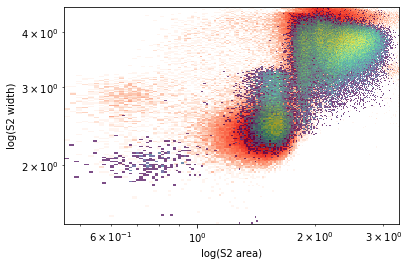

In [67]:
bins = 200
plt.hist2d(np.log10(s2_runs['area'][(s2_runs['area']>0)&(s2_runs['range_50p_area']>0)]), 
           np.log10(s2_runs['range_50p_area'][(s2_runs['range_50p_area']>0)&(s2_runs['area']>0)]), 
           bins=(bins,bins), norm=LogNorm(), cmap='Reds');
plt.hist2d(np.log10(s2_peaks['area']), np.log10(s2_peaks['range_50p_area']), bins=(bins,bins), norm=LogNorm(), alpha=0.7);
plt.xscale('log') ; plt.yscale('log')
plt.xlabel('log(S2 area)'); plt.ylabel('log(S2 width)');